In [1]:
import os
import json
import re
import matplotlib.pyplot as plt




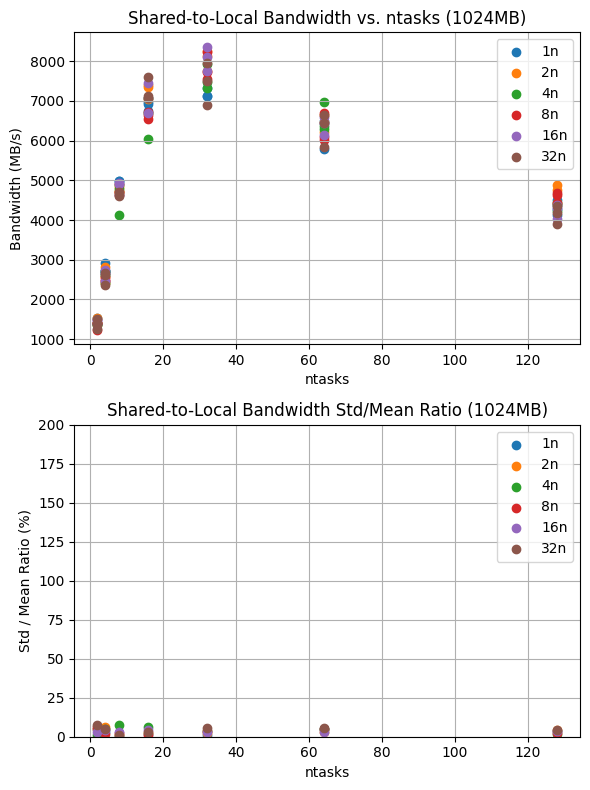

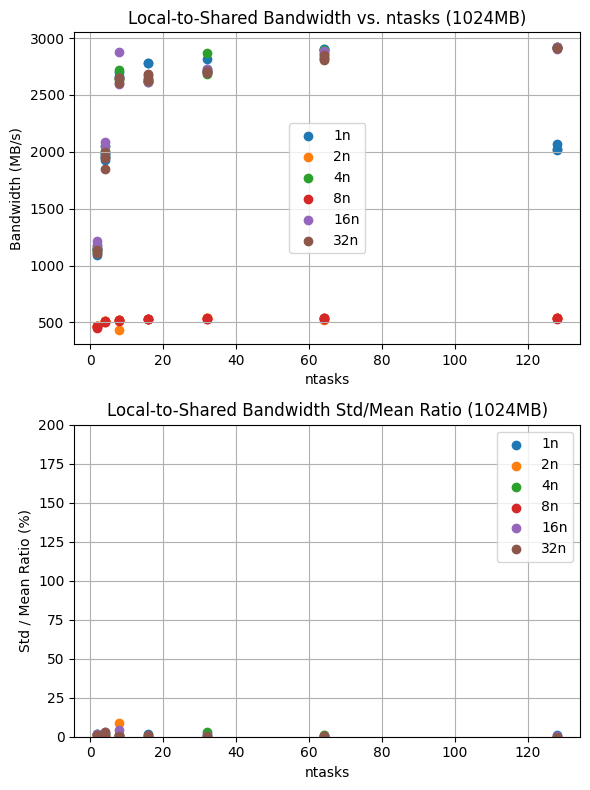

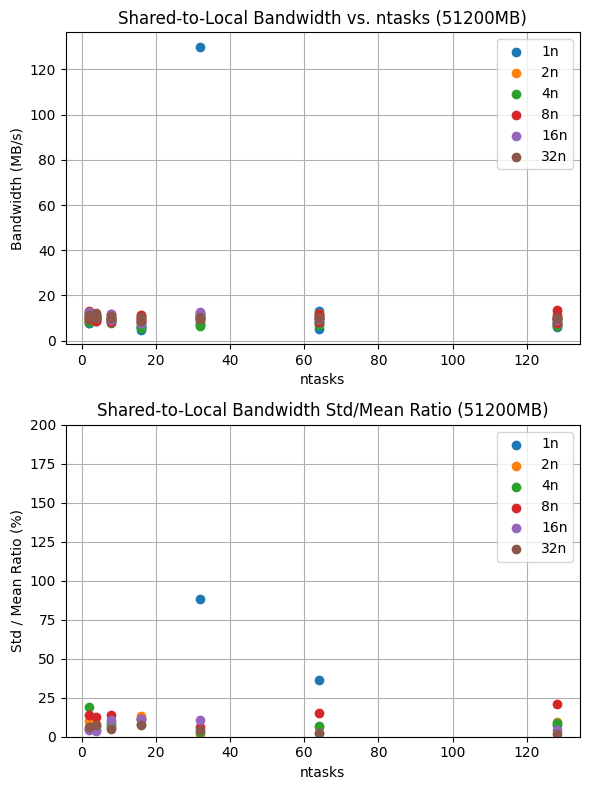

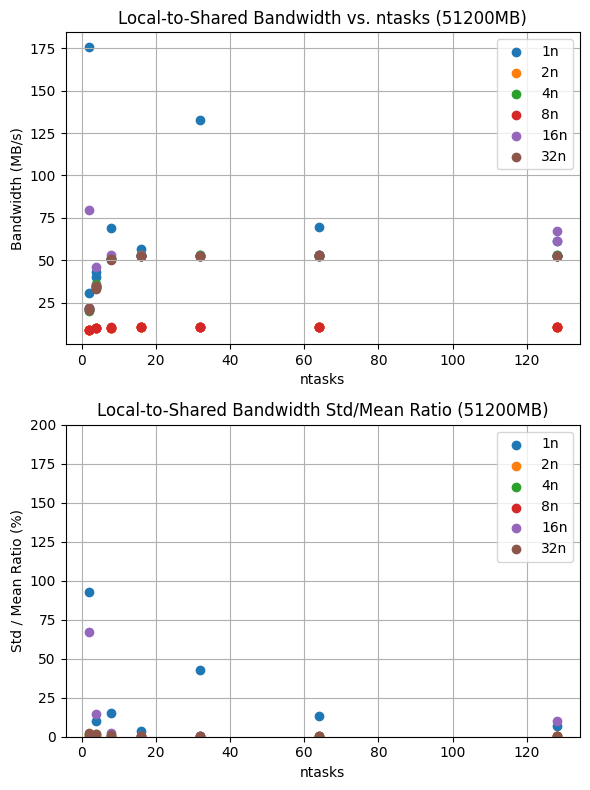

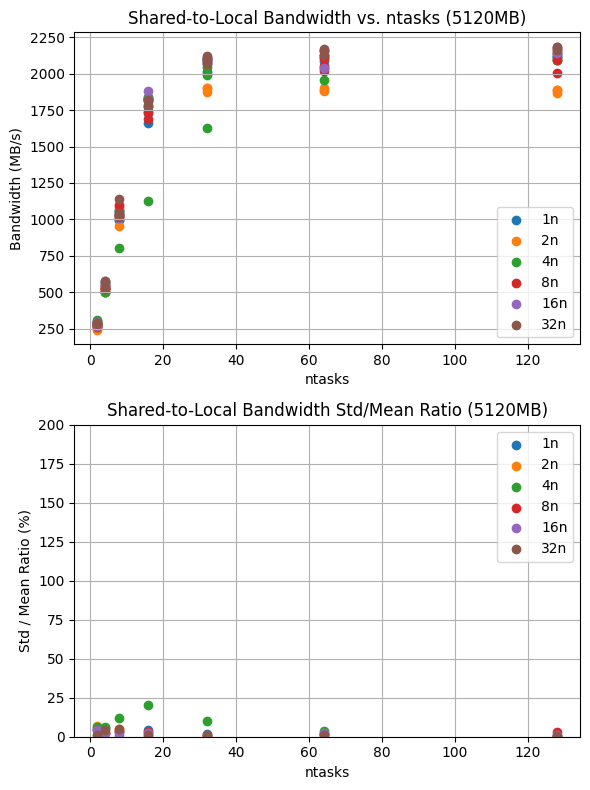

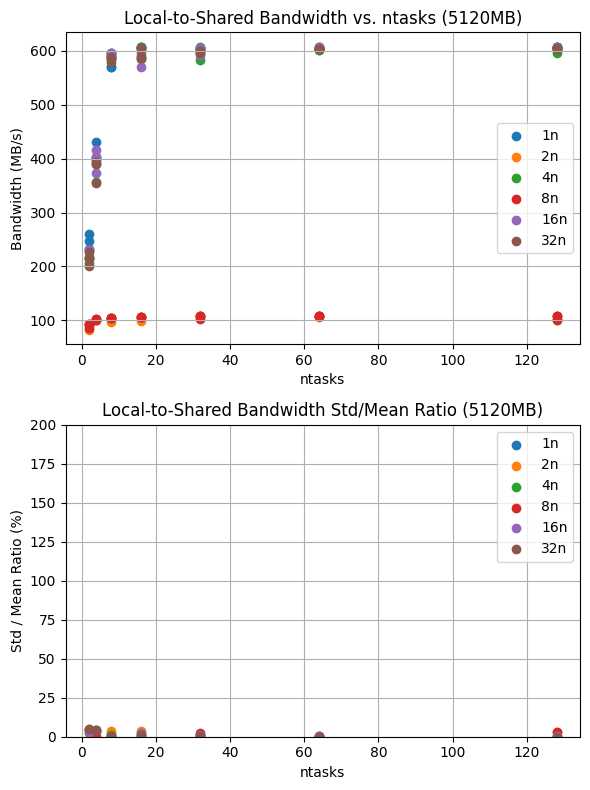

In [2]:
data_dir = "./cp_data" 
filenames = [f for f in os.listdir(data_dir) if f.startswith("PFS_to_SSD_") and f.endswith(".out")]
data = {}

for filename in filenames:
    match = re.search(r'_(\d+)n_', filename)
    if not match:
        continue
    node_count = int(match.group(1))
    
    with open(f"{data_dir}/{filename}", 'r') as f:
        for line in f:
            line = line.strip()
            if line.startswith('{'):
                record = json.loads(line)
                filesize = record.get("filesize")
                if not filesize:
                    continue
                if filesize not in data:
                    data[filesize] = {}
                if node_count not in data[filesize]:
                    data[filesize][node_count] = {"ntasks": [], "shared-to-local": [], "local-to-share": []}
                for trial_key, entry in record.items():
                    if trial_key == "filesize":
                        continue
                    data[filesize][node_count]["ntasks"].append(entry["ntasks"])
                    data[filesize][node_count]["shared-to-local"].append(entry["shared-to-local-bw(MB/s)"])
                    data[filesize][node_count]["local-to-share"].append(entry["local-to-share-bw(MB/s)"])

# Calculate averages and standard deviations
import numpy as np
averages = {}
std_devs = {}
for filesize, nodes in data.items():
    averages[filesize] = {}
    std_devs[filesize] = {}
    for node_count, metrics in nodes.items():
        averages[filesize][node_count] = {
            "shared-to-local": np.mean(metrics["shared-to-local"]) if metrics["shared-to-local"] else 0,
            "local-to-share": np.mean(metrics["local-to-share"]) if metrics["local-to-share"] else 0,
        }
        std_devs[filesize][node_count] = {
            "shared-to-local": ( np.std(metrics["shared-to-local"])) if metrics["shared-to-local"] else 0,
            "local-to-share": ( np.std(metrics["local-to-share"])) if metrics["local-to-share"] else 0,
        }

for filesize in sorted(data.keys()):
    # Plot shared-to-local: bandwidth, std dev, and std/mean ratio
    fig, (ax1, ax3) = plt.subplots(2, 1, figsize=(6, 8))
    for node in sorted(data[filesize].keys()):
        ax1.scatter(data[filesize][node]["ntasks"], data[filesize][node]["shared-to-local"], label=f"{node}n")
    ax1.set_xlabel("ntasks")
    ax1.set_ylabel("Bandwidth (MB/s)")
    ax1.set_title(f"Shared-to-Local Bandwidth vs. ntasks ({filesize})")
    ax1.legend()
    ax1.grid(True)

    for node in sorted(data[filesize].keys()):
        std_ratios = []
        unique_ntasks = sorted(set(data[filesize][node]["ntasks"]))
        for ntask in unique_ntasks:
            indices = [i for i, x in enumerate(data[filesize][node]["ntasks"]) if x == ntask]
            values = [data[filesize][node]["shared-to-local"][i] for i in indices]
            std_ratio = (100 * np.std(values) / np.mean(values)) if np.mean(values) > 0 else 0
            std_ratios.append(std_ratio)
        ax3.scatter(unique_ntasks, std_ratios, label=f"{node}n")
    ax3.set_xlabel("ntasks")
    ax3.set_ylabel("Std / Mean Ratio (%)")
    ax3.set_title(f"Shared-to-Local Bandwidth Std/Mean Ratio ({filesize})")
    ax3.legend()
    ax3.grid(True)
    ax3.set_ylim(0, 200)

    plt.tight_layout()

    # Plot local-to-share: bandwidth, std dev, and std/mean ratio
    fig, (ax1, ax3) = plt.subplots(2, 1, figsize=(6, 8))
    for node in sorted(data[filesize].keys()):
        ax1.scatter(data[filesize][node]["ntasks"], data[filesize][node]["local-to-share"], label=f"{node}n")
    ax1.set_xlabel("ntasks")
    ax1.set_ylabel("Bandwidth (MB/s)")
    ax1.set_title(f"Local-to-Shared Bandwidth vs. ntasks ({filesize})")
    ax1.legend()
    ax1.grid(True)

    for node in sorted(data[filesize].keys()):
        std_ratios = []
        unique_ntasks = sorted(set(data[filesize][node]["ntasks"]))
        for ntask in unique_ntasks:
            indices = [i for i, x in enumerate(data[filesize][node]["ntasks"]) if x == ntask]
            values = [data[filesize][node]["local-to-share"][i] for i in indices]
            std_ratio = (100 * np.std(values) / np.mean(values)) if np.mean(values) > 0 else 0
            std_ratios.append(std_ratio)
        ax3.scatter(unique_ntasks, std_ratios, label=f"{node}n")
    ax3.set_xlabel("ntasks")
    ax3.set_ylabel("Std / Mean Ratio (%)")
    ax3.set_title(f"Local-to-Shared Bandwidth Std/Mean Ratio ({filesize})")
    ax3.legend()
    ax3.grid(True)
    ax3.set_ylim(0, 200)

    plt.tight_layout()

In [3]:
import pandas as pd

IOR_PARAMS = [
    'operation', 'randomOffset', 'transferSize', 
    'aggregateFilesizeMB', 'numTasks', 'totalTime', 
    'numNodes', 'tasksPerNode', 'parallelism', 'trMiB', "storageType"
]

rows = []

for filesize, nodes in data.items():
    filesize_mb = int(filesize.replace("MB", ""))
    for num_nodes, metrics in nodes.items():
        ntasks_list = metrics['ntasks']
        shared_bw_list = metrics['shared-to-local']
        local_bw_list = metrics['local-to-share']
        for i in range(len(ntasks_list)):
            ntasks = ntasks_list[i]
            # Shared-to-local (cp)
            rows.append({
                'operation': 'cp',
                'randomOffset': 0,
                'transferSize': 4096,
                'aggregateFilesizeMB': filesize_mb,
                'numTasks': ntasks,
                'totalTime': -1,
                'numNodes': num_nodes,
                'tasksPerNode': ntasks // num_nodes if num_nodes > 0 else None,
                'parallelism': ntasks,
                'trMiB': shared_bw_list[i],
                'storageType': 'beegfs-ssd'
            })
            # Local-to-shared (cp)
            rows.append({
                'operation': 'cp',
                'randomOffset': 0,
                'transferSize': 4096,
                'aggregateFilesizeMB': filesize_mb,
                'numTasks': ntasks,
                'totalTime': -1,
                'numNodes': num_nodes,
                'tasksPerNode': ntasks // num_nodes if num_nodes > 0 else None,
                'parallelism': ntasks,
                'trMiB': local_bw_list[i],
                'storageType': 'ssd-beegfs'
            })
            
data_df = pd.DataFrame(rows, columns=IOR_PARAMS)

print(data_df.head(5))

  operation  randomOffset  transferSize  aggregateFilesizeMB  numTasks  \
0        cp             0          4096                 1024         2   
1        cp             0          4096                 1024         2   
2        cp             0          4096                 1024         4   
3        cp             0          4096                 1024         4   
4        cp             0          4096                 1024         8   

   totalTime  numNodes  tasksPerNode  parallelism    trMiB storageType  
0         -1         1             2            2  1544.56  beegfs-ssd  
1         -1         1             2            2  1095.59  ssd-beegfs  
2         -1         1             4            4  2724.01  beegfs-ssd  
3         -1         1             4            4  1981.16  ssd-beegfs  
4         -1         1             8            8  4972.14  beegfs-ssd  


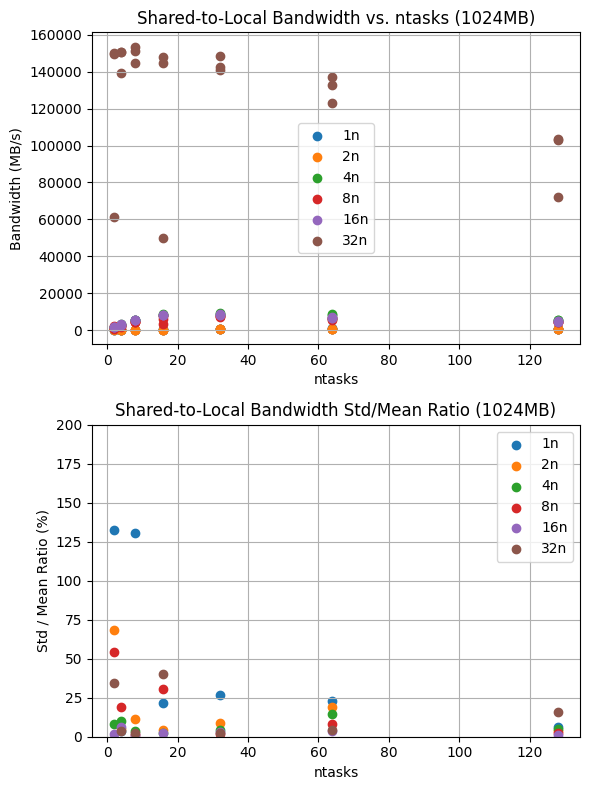

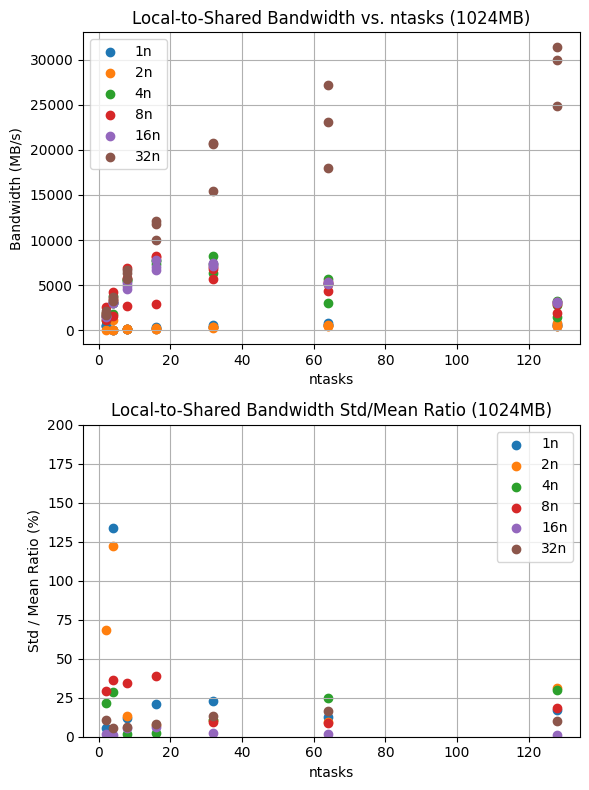

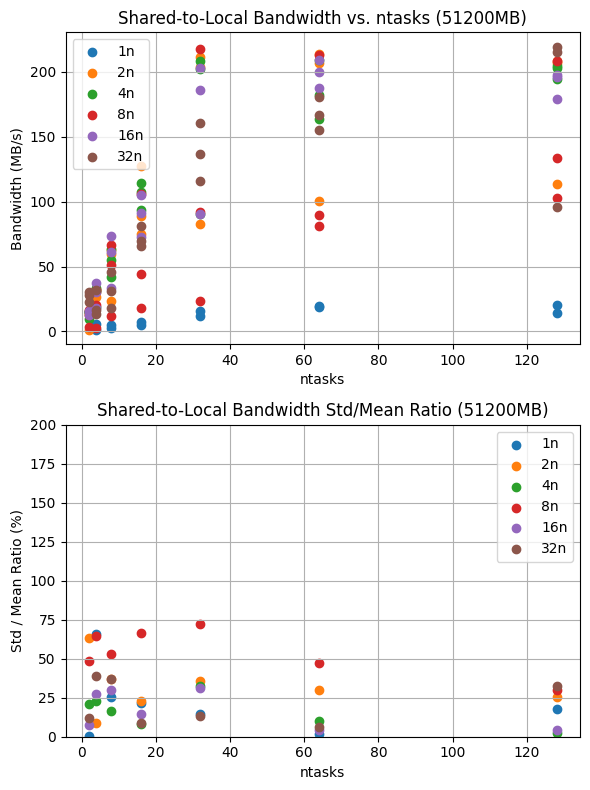

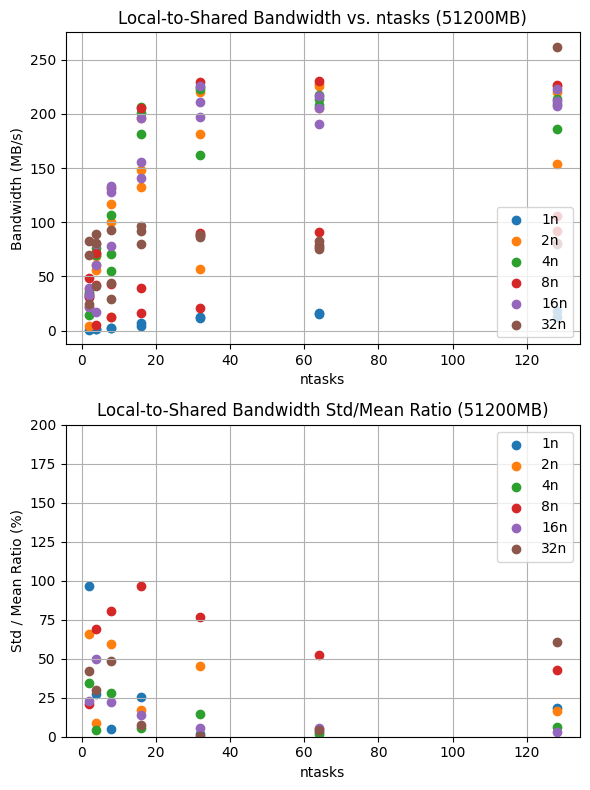

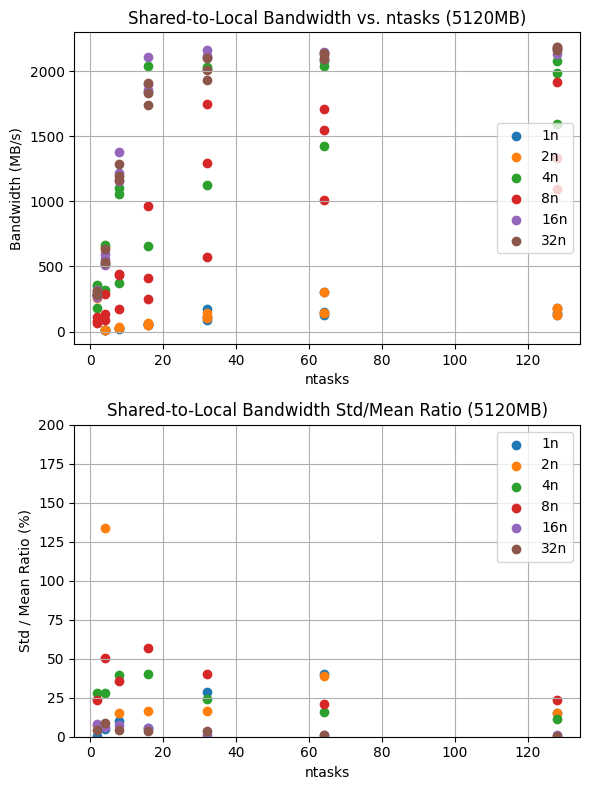

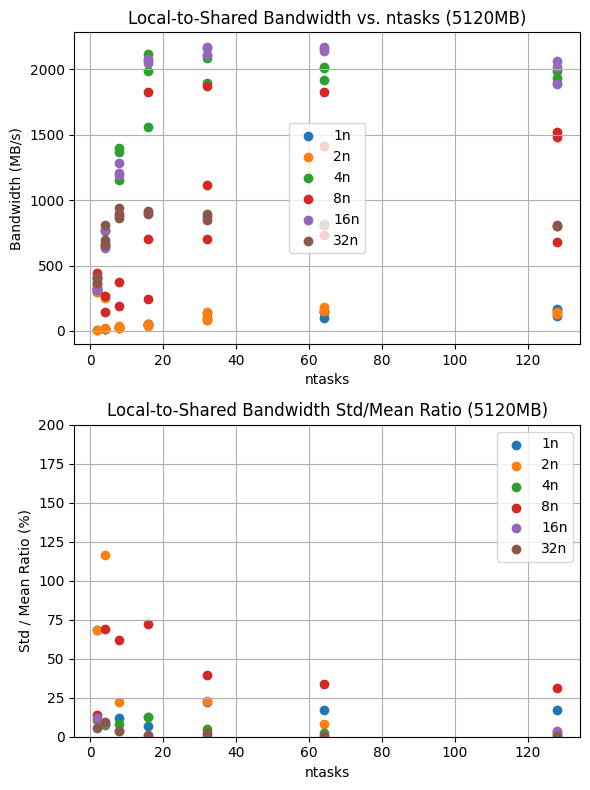

In [4]:
# /home/tang584/scripts/linux_resource_detect/update_average_values.py

import os
import re
import json
import matplotlib.pyplot as plt

filenames = [f for f in os.listdir(data_dir) if f.startswith("PFS_to_tmpfs_") and f.endswith(".out")]
data = {}

for filename in filenames:
    match = re.search(r'_(\d+)n_', filename)
    if not match:
        continue
    node_count = int(match.group(1))
    
    with open(f"{data_dir}/{filename}", 'r') as f:
        for line in f:
            line = line.strip()
            if line.startswith('{'):
                record = json.loads(line)
                filesize = record.get("filesize")
                if not filesize:
                    continue
                if filesize not in data:
                    data[filesize] = {}
                if node_count not in data[filesize]:
                    data[filesize][node_count] = {"ntasks": [], "shared-to-local": [], "local-to-share": []}
                for trial_key, entry in record.items():
                    if trial_key == "filesize":
                        continue
                    data[filesize][node_count]["ntasks"].append(entry["ntasks"])
                    data[filesize][node_count]["shared-to-local"].append(entry["shared-to-local-bw(MB/s)"])
                    data[filesize][node_count]["local-to-share"].append(entry["local-to-share-bw(MB/s)"])

# Calculate averages and standard deviations
import numpy as np
averages = {}
std_devs = {}
for filesize, nodes in data.items():
    averages[filesize] = {}
    std_devs[filesize] = {}
    for node_count, metrics in nodes.items():
        averages[filesize][node_count] = {
            "shared-to-local": np.mean(metrics["shared-to-local"]) if metrics["shared-to-local"] else 0,
            "local-to-share": np.mean(metrics["local-to-share"]) if metrics["local-to-share"] else 0,
        }
        std_devs[filesize][node_count] = {
            "shared-to-local": np.std(metrics["shared-to-local"]) if metrics["shared-to-local"] else 0,
            "local-to-share":  np.std(metrics["local-to-share"]) if metrics["local-to-share"] else 0,
        }

# Plotting
for filesize in sorted(data.keys()):
    # Plot shared-to-local: bandwidth, std dev, and std/mean ratio
    fig, (ax1, ax3) = plt.subplots(2, 1, figsize=(6, 8))
    for node in sorted(data[filesize].keys()):
        ax1.scatter(data[filesize][node]["ntasks"], data[filesize][node]["shared-to-local"], label=f"{node}n")
    ax1.set_xlabel("ntasks")
    ax1.set_ylabel("Bandwidth (MB/s)")
    ax1.set_title(f"Shared-to-Local Bandwidth vs. ntasks ({filesize})")
    ax1.legend()
    ax1.grid(True)

    for node in sorted(data[filesize].keys()):
        std_ratios = []
        unique_ntasks = sorted(set(data[filesize][node]["ntasks"]))
        for ntask in unique_ntasks:
            indices = [i for i, x in enumerate(data[filesize][node]["ntasks"]) if x == ntask]
            values = [data[filesize][node]["shared-to-local"][i] for i in indices]
            std_ratio = (100 * np.std(values) / np.mean(values)) if np.mean(values) > 0 else 0
            std_ratios.append(std_ratio)
        ax3.scatter(unique_ntasks, std_ratios, label=f"{node}n")
    ax3.set_xlabel("ntasks")
    ax3.set_ylabel("Std / Mean Ratio (%)")
    ax3.set_title(f"Shared-to-Local Bandwidth Std/Mean Ratio ({filesize})")
    ax3.legend()
    ax3.grid(True)
    ax3.set_ylim(0, 200)

    plt.tight_layout()

    # Plot local-to-share: bandwidth, std dev, and std/mean ratio
    fig, (ax1, ax3) = plt.subplots(2, 1, figsize=(6, 8))
    for node in sorted(data[filesize].keys()):
        ax1.scatter(data[filesize][node]["ntasks"], data[filesize][node]["local-to-share"], label=f"{node}n")
    ax1.set_xlabel("ntasks")
    ax1.set_ylabel("Bandwidth (MB/s)")
    ax1.set_title(f"Local-to-Shared Bandwidth vs. ntasks ({filesize})")
    ax1.legend()
    ax1.grid(True)

    for node in sorted(data[filesize].keys()):
        std_ratios = []
        unique_ntasks = sorted(set(data[filesize][node]["ntasks"]))
        for ntask in unique_ntasks:
            indices = [i for i, x in enumerate(data[filesize][node]["ntasks"]) if x == ntask]
            values = [data[filesize][node]["local-to-share"][i] for i in indices]
            std_ratio = (100 * np.std(values) / np.mean(values)) if np.mean(values) > 0 else 0
            std_ratios.append(std_ratio)
        ax3.scatter(unique_ntasks, std_ratios, label=f"{node}n")
    ax3.set_xlabel("ntasks")
    ax3.set_ylabel("Std / Mean Ratio (%)")
    ax3.set_title(f"Local-to-Shared Bandwidth Std/Mean Ratio ({filesize})")
    ax3.legend()
    ax3.grid(True)
    ax3.set_ylim(0, 200)

    plt.tight_layout()

In [5]:
import pandas as pd

IOR_PARAMS = [
    'operation', 'randomOffset', 'transferSize', 
    'aggregateFilesizeMB', 'numTasks', 'totalTime', 
    'numNodes', 'tasksPerNode', 'parallelism', 'trMiB', "storageType"
]

rows = []

for filesize, nodes in data.items():
    filesize_mb = int(filesize.replace("MB", ""))
    for num_nodes, metrics in nodes.items():
        ntasks_list = metrics['ntasks']
        shared_bw_list = metrics['shared-to-local']
        local_bw_list = metrics['local-to-share']
        for i in range(len(ntasks_list)):
            ntasks = ntasks_list[i]
            # Shared-to-local (cp)
            rows.append({
                'operation': 'cp',
                'randomOffset': 0,
                'transferSize': 4096,
                'aggregateFilesizeMB': filesize_mb,
                'numTasks': ntasks,
                'totalTime': -1,
                'numNodes': num_nodes,
                'tasksPerNode': ntasks // num_nodes if num_nodes > 0 else None,
                'parallelism': ntasks,
                'trMiB': shared_bw_list[i],
                'storageType': 'beegfs-tmpfs'
            })
            # Local-to-shared (cp)
            rows.append({
                'operation': 'cp',
                'randomOffset': 0,
                'transferSize': 4096,
                'aggregateFilesizeMB': filesize_mb,
                'numTasks': ntasks,
                'totalTime': -1,
                'numNodes': num_nodes,
                'tasksPerNode': ntasks // num_nodes if num_nodes > 0 else None,
                'parallelism': ntasks,
                'trMiB': local_bw_list[i],
                'storageType': 'tmpfs-beegfs'
            })
            
# data_df = pd.DataFrame(rows, columns=IOR_PARAMS)
data_df = pd.concat([data_df, pd.DataFrame(rows, columns=IOR_PARAMS)], ignore_index=True)


print(data_df.head(5))

  operation  randomOffset  transferSize  aggregateFilesizeMB  numTasks  \
0        cp             0          4096                 1024         2   
1        cp             0          4096                 1024         2   
2        cp             0          4096                 1024         4   
3        cp             0          4096                 1024         4   
4        cp             0          4096                 1024         8   

   totalTime  numNodes  tasksPerNode  parallelism    trMiB storageType  
0         -1         1             2            2  1544.56  beegfs-ssd  
1         -1         1             2            2  1095.59  ssd-beegfs  
2         -1         1             4            4  2724.01  beegfs-ssd  
3         -1         1             4            4  1981.16  ssd-beegfs  
4         -1         1             8            8  4972.14  beegfs-ssd  


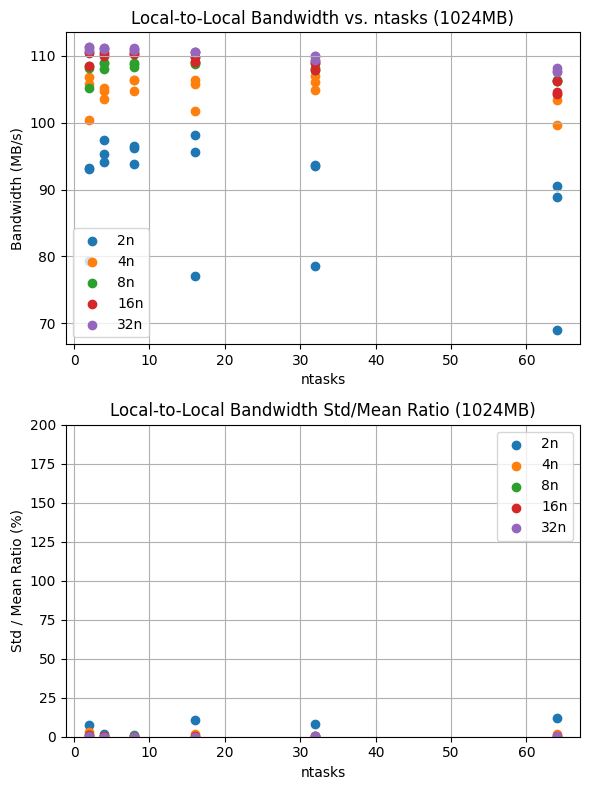

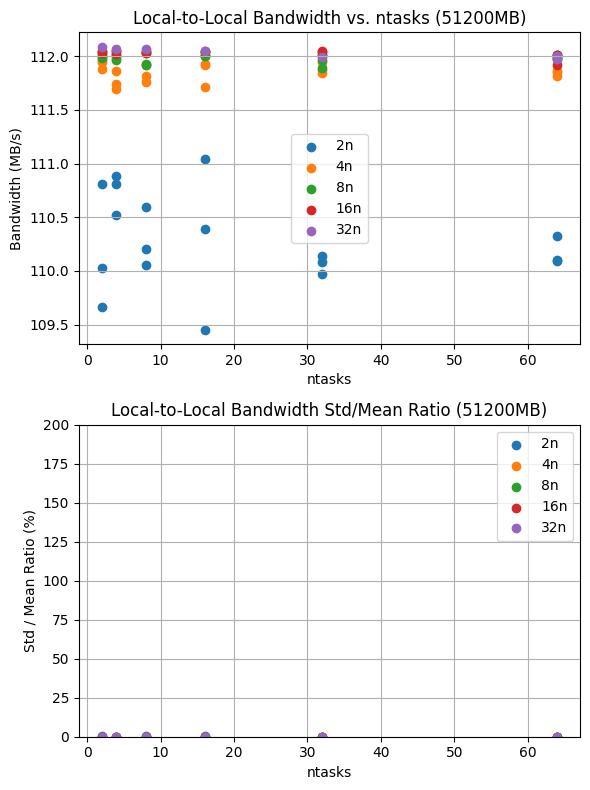

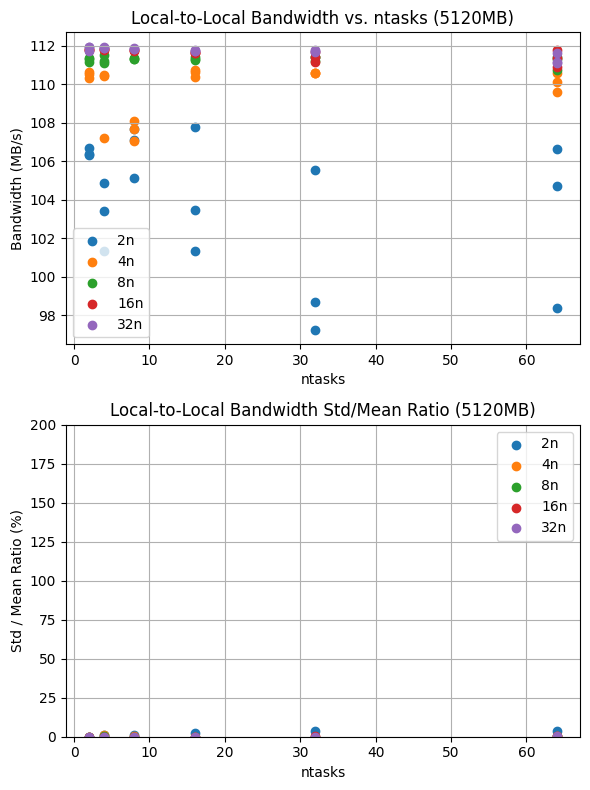

In [6]:
# /home/tang584/scripts/linux_resource_detect/update_average_values.py

import os
import re
import json
import matplotlib.pyplot as plt

filenames = [f for f in os.listdir(data_dir) if f.startswith("SSD_to_SSD_") and f.endswith(".out")]
data = {}

for filename in filenames:
    match = re.search(r'_(\d+)n_', filename)
    if not match:
        continue
    node_count = int(match.group(1))
    
    with open(f"{data_dir}/{filename}", 'r') as f:
        for line in f:
            line = line.strip()
            if line.startswith('{'):
                record = json.loads(line)
                filesize = record.get("filesize")
                if not filesize:
                    continue
                if filesize not in data:
                    data[filesize] = {}
                if node_count not in data[filesize]:
                    data[filesize][node_count] = {"ntasks": [], "local-to-local": []}
                for trial_key, entry in record.items():
                    if trial_key == "filesize":
                        continue
                    data[filesize][node_count]["ntasks"].append(entry["ntasks"])
                    data[filesize][node_count]["local-to-local"].append(entry["local-to-local-bw(MB/s)"])

# Calculate averages and standard deviations
import numpy as np
averages = {}
std_devs = {}
for filesize, nodes in data.items():
    averages[filesize] = {}
    std_devs[filesize] = {}
    for node_count, metrics in nodes.items():
        averages[filesize][node_count] = {
            "local-to-local": np.mean(metrics["local-to-local"]) if metrics["local-to-local"] else 0,
        }
        std_devs[filesize][node_count] = {
            "local-to-local": np.std(metrics["local-to-local"]) if metrics["local-to-local"] else 0,
        }

# Plotting
for filesize in sorted(data.keys()):
    # Plot shared-to-local: bandwidth, std dev, and std/mean ratio
    fig, (ax1, ax3) = plt.subplots(2, 1, figsize=(6, 8))
    for node in sorted(data[filesize].keys()):
        ax1.scatter(data[filesize][node]["ntasks"], data[filesize][node]["local-to-local"], label=f"{node}n")
    ax1.set_xlabel("ntasks")
    ax1.set_ylabel("Bandwidth (MB/s)")
    ax1.set_title(f"Local-to-Local Bandwidth vs. ntasks ({filesize})")
    ax1.legend()
    ax1.grid(True)

    for node in sorted(data[filesize].keys()):
        std_ratios = []
        unique_ntasks = sorted(set(data[filesize][node]["ntasks"]))
        for ntask in unique_ntasks:
            indices = [i for i, x in enumerate(data[filesize][node]["ntasks"]) if x == ntask]
            values = [data[filesize][node]["local-to-local"][i] for i in indices]
            std_ratio = (100 * np.std(values) / np.mean(values)) if np.mean(values) > 0 else 0
            std_ratios.append(std_ratio)
        ax3.scatter(unique_ntasks, std_ratios, label=f"{node}n")
    ax3.set_xlabel("ntasks")
    ax3.set_ylabel("Std / Mean Ratio (%)")
    ax3.set_title(f"Local-to-Local Bandwidth Std/Mean Ratio ({filesize})")
    ax3.legend()
    ax3.grid(True)
    ax3.set_ylim(0, 200)

    plt.tight_layout()


In [7]:
import pandas as pd

IOR_PARAMS = [
    'operation', 'randomOffset', 'transferSize', 
    'aggregateFilesizeMB', 'numTasks', 'totalTime', 
    'numNodes', 'tasksPerNode', 'parallelism', 'trMiB', "storageType"
]

rows = []

for filesize, nodes in data.items():
    filesize_mb = int(filesize.replace("MB", ""))
    for num_nodes, metrics in nodes.items():
        ntasks_list = metrics['ntasks']
        local_bw_list = metrics['local-to-local']
        for i in range(len(ntasks_list)):
            ntasks = ntasks_list[i]
            # Local-to-shared (scp)
            rows.append({
                'operation': 'scp',
                'randomOffset': 0,
                'transferSize': 4096,
                'aggregateFilesizeMB': filesize_mb,
                'numTasks': ntasks,
                'totalTime': -1,
                'numNodes': num_nodes,
                'tasksPerNode': ntasks // num_nodes if num_nodes > 0 else None,
                'parallelism': ntasks,
                'trMiB': local_bw_list[i],
                'storageType': 'ssd-ssd'
            })
            
data_df = pd.concat([data_df, pd.DataFrame(rows, columns=IOR_PARAMS)], ignore_index=True)


print(data_df.head(5))

  operation  randomOffset  transferSize  aggregateFilesizeMB  numTasks  \
0        cp             0          4096                 1024         2   
1        cp             0          4096                 1024         2   
2        cp             0          4096                 1024         4   
3        cp             0          4096                 1024         4   
4        cp             0          4096                 1024         8   

   totalTime  numNodes  tasksPerNode  parallelism    trMiB storageType  
0         -1         1             2            2  1544.56  beegfs-ssd  
1         -1         1             2            2  1095.59  ssd-beegfs  
2         -1         1             4            4  2724.01  beegfs-ssd  
3         -1         1             4            4  1981.16  ssd-beegfs  
4         -1         1             8            8  4972.14  beegfs-ssd  


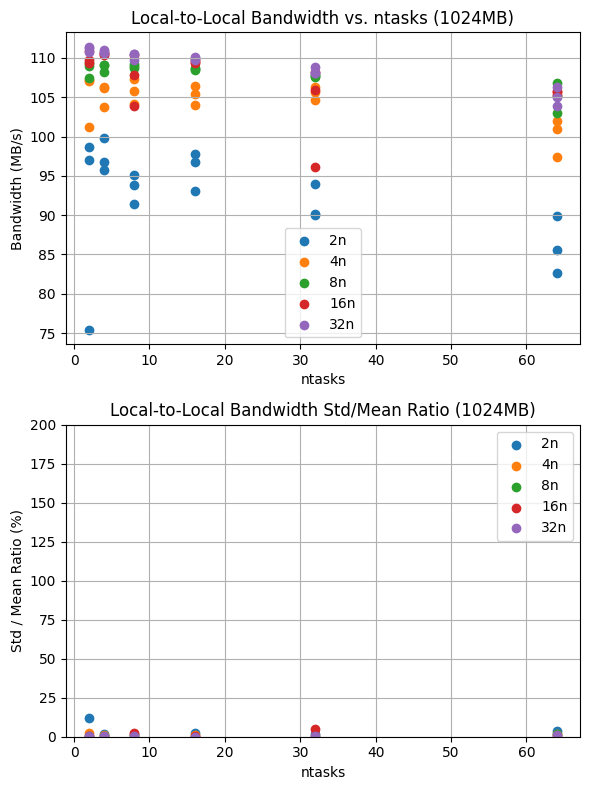

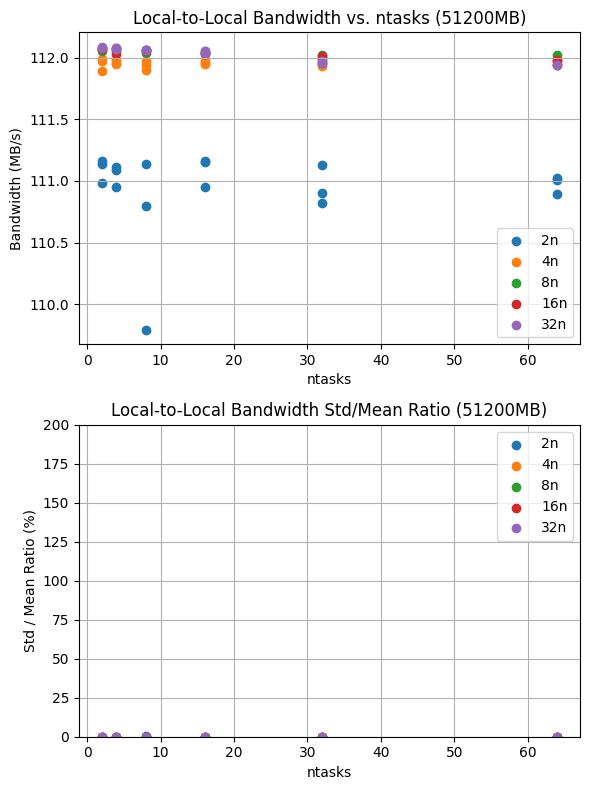

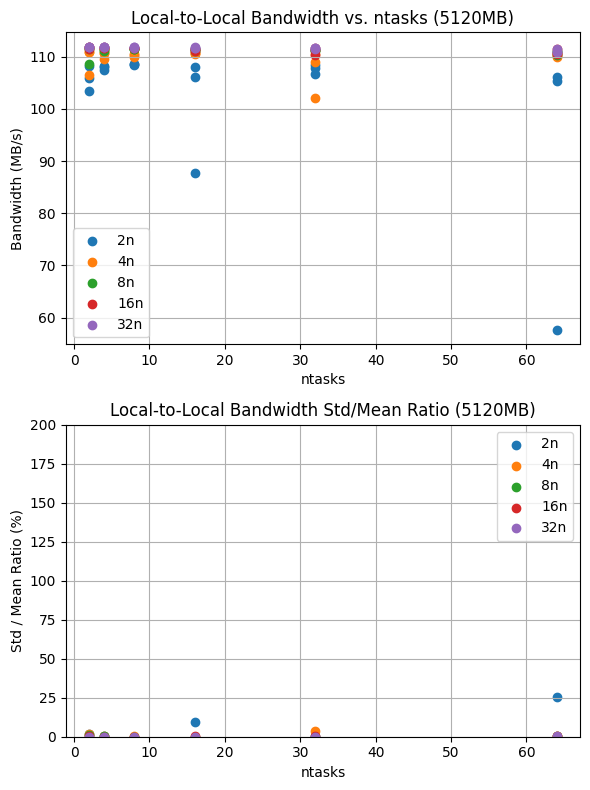

In [8]:
# /home/tang584/scripts/linux_resource_detect/update_average_values.py

import os
import re
import json
import matplotlib.pyplot as plt

filenames = [f for f in os.listdir(data_dir) if f.startswith("tmpfs_to_tmpfs_") and f.endswith(".out")]
data = {}

for filename in filenames:
    match = re.search(r'_(\d+)n_', filename)
    if not match:
        continue
    node_count = int(match.group(1))
    
    with open(f"{data_dir}/{filename}", 'r') as f:
        for line in f:
            line = line.strip()
            if line.startswith('{'):
                record = json.loads(line)
                filesize = record.get("filesize")
                if not filesize:
                    continue
                if filesize not in data:
                    data[filesize] = {}
                if node_count not in data[filesize]:
                    data[filesize][node_count] = {"ntasks": [], "local-to-local": []}
                for trial_key, entry in record.items():
                    if trial_key == "filesize":
                        continue
                    data[filesize][node_count]["ntasks"].append(entry["ntasks"])
                    data[filesize][node_count]["local-to-local"].append(entry["local-to-local-bw(MB/s)"])

# Calculate averages and standard deviations
import numpy as np
averages = {}
std_devs = {}
for filesize, nodes in data.items():
    averages[filesize] = {}
    std_devs[filesize] = {}
    for node_count, metrics in nodes.items():
        averages[filesize][node_count] = {
            "local-to-local": np.mean(metrics["local-to-local"]) if metrics["local-to-local"] else 0,
        }
        std_devs[filesize][node_count] = {
            "local-to-local": np.std(metrics["local-to-local"]) if metrics["local-to-local"] else 0,
        }

# Plotting
for filesize in sorted(data.keys()):
    # Plot shared-to-local: bandwidth, std dev, and std/mean ratio
    fig, (ax1, ax3) = plt.subplots(2, 1, figsize=(6, 8))
    for node in sorted(data[filesize].keys()):
        ax1.scatter(data[filesize][node]["ntasks"], data[filesize][node]["local-to-local"], label=f"{node}n")
    ax1.set_xlabel("ntasks")
    ax1.set_ylabel("Bandwidth (MB/s)")
    ax1.set_title(f"Local-to-Local Bandwidth vs. ntasks ({filesize})")
    ax1.legend()
    ax1.grid(True)


    for node in sorted(data[filesize].keys()):
        std_ratios = []
        unique_ntasks = sorted(set(data[filesize][node]["ntasks"]))
        for ntask in unique_ntasks:
            indices = [i for i, x in enumerate(data[filesize][node]["ntasks"]) if x == ntask]
            values = [data[filesize][node]["local-to-local"][i] for i in indices]
            std_ratio = (100 * np.std(values) / np.mean(values)) if np.mean(values) > 0 else 0
            std_ratios.append(std_ratio)
        ax3.scatter(unique_ntasks, std_ratios, label=f"{node}n")
    ax3.set_xlabel("ntasks")
    ax3.set_ylabel("Std / Mean Ratio (%)")
    ax3.set_title(f"Local-to-Local Bandwidth Std/Mean Ratio ({filesize})")
    ax3.legend()
    ax3.grid(True)
    ax3.set_ylim(0, 200)

    plt.tight_layout()


In [9]:
import pandas as pd

IOR_PARAMS = [
    'operation', 'randomOffset', 'transferSize', 
    'aggregateFilesizeMB', 'numTasks', 'totalTime', 
    'numNodes', 'tasksPerNode', 'parallelism', 'trMiB', "storageType"
]

rows = []

for filesize, nodes in data.items():
    filesize_mb = int(filesize.replace("MB", ""))
    for num_nodes, metrics in nodes.items():
        ntasks_list = metrics['ntasks']
        local_bw_list = metrics['local-to-local']
        for i in range(len(ntasks_list)):
            ntasks = ntasks_list[i]
            # Local-to-shared (scp)
            rows.append({
                'operation': 'scp',
                'randomOffset': 0,
                'transferSize': 4096,
                'aggregateFilesizeMB': filesize_mb,
                'numTasks': ntasks,
                'totalTime': -1,
                'numNodes': num_nodes,
                'tasksPerNode': ntasks // num_nodes if num_nodes > 0 else None,
                'parallelism': ntasks,
                'trMiB': local_bw_list[i],
                'storageType': 'tmpfs-tmpfs'
            })
            
data_df = pd.concat([data_df, pd.DataFrame(rows, columns=IOR_PARAMS)], ignore_index=True)


print(data_df.head(5))

  operation  randomOffset  transferSize  aggregateFilesizeMB  numTasks  \
0        cp             0          4096                 1024         2   
1        cp             0          4096                 1024         2   
2        cp             0          4096                 1024         4   
3        cp             0          4096                 1024         4   
4        cp             0          4096                 1024         8   

   totalTime  numNodes  tasksPerNode  parallelism    trMiB storageType  
0         -1         1             2            2  1544.56  beegfs-ssd  
1         -1         1             2            2  1095.59  ssd-beegfs  
2         -1         1             4            4  2724.01  beegfs-ssd  
3         -1         1             4            4  1981.16  ssd-beegfs  
4         -1         1             8            8  4972.14  beegfs-ssd  


In [10]:
print(data_df.shape)

# save data_df to csv
data_df.to_csv("master_move_data.csv", index=False)

(2008, 11)
